# **Projeto: Percolação por sítios em rede quadrada**
### **Programação Estatística - Projeto de Fim de Curso**

- Docente: Rafael Izbicki
- Discentes:
    - Andressa Nascimento Santos - RA 829442
    - Nicolas Magalhães Santana e Silva - RA 830225

---

# **Introdução**

A teoria da percolação é um modelo fundamental para descrever fenômenos de conexão em sistemas desordenados, como o fluxo de l ́ıquidos em meios porosos, a propagação de incêndios florestais ou a condutividade em materiais compósitos.

O objetivo deste projeto é estimar, por meio de simulação de Monte Carlo, o limiar crítico de percolação $p_c$ em uma grade quadrada bidimensional e analisar o comportamento do sistema próximo a esse ponto crítico.

As principais questões são:
- Qual o valor de $p$ a partir do qual um "caminho" de ponta a ponta na grade se torna provável?
- Como essa probabilidade varia com o tamanho da grade ($N$)?
- Qual a distribuição de tamanho do maior aglomerado _(cluster)_ de sítios conectados, especialmente no limiar crítico?

---

# **Descrição do modelo gerador de dados**

## Orientações
O modelo é uma grade (ou reticulado) quadrada $\mathcal{L}$ de dimensões $N \times X$. Cada sítio $(i, j) \in \mathcal{L}$ pode estar em um de dois estados: "ocupado" ou "vazio". A ocupação de cada sítio é um evento independente de Bernoulli com probabilidade $p$, ou seja, $P(\text{sítio }(i, j)\text{ ocupado})=p$.

Um _cluster_ é definido como um conjunto de sítios ocupados adjacentes (vizinhos de von Neumann: acima, abaixo à esquerda, à direita). 

Diz-se que o sistema "percola" se existir um cluster que conecte a borda superior à borda inferior da grade (ou a esquerda à direita).

A probabilidade de percolação, $\theta(p,N)$, é a probabilidade de que uma grade $N \times N$ gerada com parâmetro $p$ percole.

O limiar crítico $p_c$ é definido no limite $N \rightarrow \infty$ como o valor de $p$ em que $\theta(p)$ transita de $0$ para $1$.

## Execução

Para por em prática o modelo gerador de dados, utilizamos as seguintes bibliotecas Python: **NumPy, Matplotlib e SciPy** (da qual foi importado especificamente o pacote `ndimage`, para identificação de clusters em grades)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

---

# **Metodologia da simulação**

## Orientações:
A simulação seguirá os seguintes passos para um dado par $(N, p)$:
1. **Geração da Grade:** Crie uma matriz $N \times N$ e preencha cada célula com $1$ (ocupado) com probabilidade $p$ e $0$ (vazio) com probabilidade $1-p$.

2. **Verificação de Percolação:** Verifique se, na configuração gerada, é possível ir da borda inferior para a superior.

3. **Estimação de $p_c(N)$**: Para um dado $N$, a probabilidade de percolação $\theta(p, N)$ será estimada pela frequência de percolação em um grande número de simulações. O limiar finito, $p_c(N)$, é tipicamente definido como o valor de $p$ para o qual $θ(p, N) \approx \frac{1}{2}$. Isso pode ser encontrado varrendo $p$ em uma malha fina ou usando um método de busca (e.g., busca binária) para encontrar o ponto de cruzamento. A extrapolação para o limite $N \rightarrow \infty$ pode ser investigada através da teoria de escala de tamanho finito, plotando $p_c(N)$ versus $1/N$ e analisando o comportamento assintótico.

## Execução

### **Algoritmo de simulação de percolação**
Nesse algoritmo, realizamos os passos 1 (Geração da grade) e 2 (Verificação de percolação).

No código, uma grade, em forma de matriz, é gerada aleatoriamente utilizando o NumPy e etiquetada através do pacote ndimage do SciPy.

A partir da matriz etiquetada, verificamos se houve ou não percolação no sistema conferindo se existem ou não interseção entre etiquetas de clusters na primeira e última linhas da matriz, ou na primeira e última coluna da matriz. Caso hajam interseções, é retornado que o sistema percolou. Outras métricas retornadas pelo algoritmo são o número de clusters e o tamanho do maior cluster.

In [5]:
def simulacao_percolacao(N, p):
  ''' Recebe os parâmetros N (o tamanho da matriz será NxN) e p (probabilidade da entrada da matriz ser 1, e 0 caso contrário).
Retorna se a matriz percolou, o número de clusters e o tamanho do maior cluster'''
  percolou = False
  maior_cluster = 0
  num_clusters = 0

  grade = np.random.rand(N, N) < p
  grade = np.where(grade, 1, 0)
  if not np.any(grade):
    return False, 0, 0
  # Se a matriz for inteiramente de zeros, já retorna que não percola e não teve clusters

  estrutura = ndimage.generate_binary_structure(rank=2, connectivity=1)
  # Define a estrutura de Vizinhos de von Neumann que será utilizada para identificar os clusters nas grades

  grade_clusters, num_clusters = ndimage.label(grade, estrutura)
  # Função de etiquetar as matrizes em clusters
  coluna_1 = grade_clusters[:, 0]
  coluna_n = grade_clusters[:, -1]
  linha_1 = grade_clusters[0]
  linha_n = grade_clusters[-1]

  intersecoes_vertical = np.intersect1d(linha_1, linha_n)
  intersecoes_horizontal = np.intersect1d(coluna_1, coluna_n)

  percolou_vertical = np.any(intersecoes_vertical > 0)
  percolou_horizontal = np.any(intersecoes_horizontal > 0)
  if percolou_vertical or percolou_horizontal:
    percolou = True

  grade_clusters_d1 = np.ravel(grade_clusters)

  contagem = np.bincount(grade_clusters_d1)
  # Conta ocupação de cada etiqueta de cluster
  maior_cluster = max(contagem[1:])
  # Maior cluster é o elemento que ocupou mais sítios (excluindo o zero)

  return percolou, maior_cluster, num_clusters, grade, grade_clusters

#### Exemplo do algoritmo de simulação para um sistema aleatório com $N=7$ e $p=0.5$

In [6]:
np.random.seed(42)
perc, maior, num, grade, grade_clusters = simulacao_percolacao(7, 0.5)
print(f"Matriz gerada aleatoriamente: \n {grade} \n")

print(f"Matriz etiquetada: \n {grade_clusters} \n")

print(f"O sistema percolou? {perc}")
print(f"Qual o tamanho do maior cluster? {maior}")
print(f"Qual o número total de clusters? {num}")

Matriz gerada aleatoriamente: 
 [[1 0 0 0 1 1 1]
 [0 0 0 1 0 0 1]
 [1 1 1 0 1 1 0]
 [1 1 1 1 0 1 0]
 [0 1 0 1 1 0 0]
 [0 1 1 0 1 1 1]
 [1 0 1 0 1 0 0]] 

Matriz etiquetada: 
 [[1 0 0 0 2 2 2]
 [0 0 0 3 0 0 2]
 [4 4 4 0 5 5 0]
 [4 4 4 4 0 5 0]
 [0 4 0 4 4 0 0]
 [0 4 4 0 4 4 4]
 [6 0 4 0 4 0 0]] 

O sistema percolou? True
Qual o tamanho do maior cluster? 17
Qual o número total de clusters? 6


### **Métricas estimadas sobre clusters a partir da simulação**

Nessa função, estimamos métricas a respeito dos clusters para cada sistema $N \times N$ e probabilidade $p$, a partir do método de Monte Carlo com um número $n$ de réplicas.

As métricas estimadas incluem: tamanho dos maiores clusters, tamanho médio dos maiores clusters, número de clusters, média do número de clusters e probabilidade de percolar para cada terna $(N, p, n)$ para os casos de percolação ou não percolação dos sistemas.

In [17]:
def metricas_cluster(N, p, n):
  ''' Recebe os parâmetros N (o tamanho da matriz será NxN), p (probabilidade da entrada da matriz ser 1, e 0 caso contrário) e
n (número de amostras que desejamos gerar) e retorna métricas a respeito dos clusters nos casos de percolação e de
não percolação do sistema. '''

  tam_cluster_percola = []
  tam_cluster_nao_percola = []
  num_cluster_percola = []
  num_cluster_nao_percola = []
  total_percola, total_nao_percola = 0, 0
    
  for i in range(n):
    y = simulacao_percolacao(N, p)
    if y[0] == True:
      tam_cluster_percola.append(y[1])
      num_cluster_percola.append(y[2])
      total_percola += 1
    else:
      tam_cluster_nao_percola.append(y[1])
      num_cluster_nao_percola.append(y[2])
      total_nao_percola += 1

  prob_percolar = total_percola / n
  prob_nao_percolar = 1 - prob_percolar

  media_tam_percola = sum(tam_cluster_percola) / total_percola if total_percola else 0
  media_tam_nao_percola = sum(tam_cluster_nao_percola) / total_nao_percola if total_nao_percola else 0

  media_num_percola = sum(num_cluster_percola) / total_percola if total_percola else 0
  media_num_nao_percola = sum(num_cluster_nao_percola) / total_nao_percola if total_nao_percola else 0
    
  return tam_cluster_percola, tam_cluster_nao_percola, prob_percolar, prob_nao_percolar, media_tam_percola, media_tam_nao_percola, total_percola, total_nao_percola, num_cluster_percola, num_cluster_nao_percola, media_num_percola, media_num_nao_percola

### **Algoritmo de estimação de limiares finitos por bissecção**

Nesse algoritmo, usamos a métrica de probabilidade de um sistema percolar ($\theta(p,N)$) estimada na função anterior para encontrar, através do método da bissecção, um valor estimado de $p$ para o qual a $\theta(p,N)$ de um sistema $N \times N$ seja igual a $0.5$. Em outras palavras, realizamos nesse algoritmo o passo 3, onde usamos o método da bissecção para estimar um limiar finito $p_c(N)$.

Utilizamos arbitrariamente um erro de $0.01$ para a bissecção.

In [21]:
def encontrar_limiar(N, n):
    def f(N, x, n):
        return metricas_cluster(N, x, n)[2]  # retorna probabilidade de percolar

    a, b = 0, 1
    x = (a + b)/2
    erro = 0.01

    while abs(f(N, x, n)-0.5) > erro:
        resultado = f(N, x, n)
        if resultado < 0.5:
            a = x
        elif resultado > 0.5:
            b = x
        x = (a + b)/2
    return x

---

# **Plano de experimento e métricas**

## Orientações

- **Tamanhos da grade:** Realize simulações para $N \in \{64, 128, 256, 512\}$.

- **Varredura de p:** Para cada $N$, execute simulações para uma faixa de valores $p$. Para cada par $(N, p)$, realize pelo menos $M = 500$ réplicas.

- **Métricas a coletar:** Para cada simulação, registre: (a) se houve percolação (booleano), (b) o tamanho do maior cluster, (c) o número total de clusters.

- **Análise do maior cluster:** No valor estimado ˆpc(N ), colete a distribuição empírica do tamanho do maior cluster em múltiplas simulações.

## Execução

### **Estimação do limiar crítico**

Com o objetivo de estimar o limiar crítico, utilizamos a função `encontrar_limiar` (que aplica diretamente todas as métricas coletadas anteriormente a partir de simulações), para encontrar os limiares finitos para sistemas de tamanho $N \in \{16, 64, 128, 256, 512, 1024\}$ com número de réplicas $n=500$.

A partir desses dados, o limiar crítico com $N \rightarrow \infty$ é estimado através de análise da convergência assintótica do gráfico de limiares finitos versus $N$.

In [ ]:
def limiar_critico(n):
  ''' Recebe como parâmetro o número de amostras (n) que serão replicadas e retorna o gráfico com a interseção entre
  os valores de N e seu limiar finito empírico'''
  lista_N = [16, 64, 128, 256, 512, 1024]
  lista_limiares = []

  for N in lista_N:
    x = encontrar_limiar(N, n)
    lista_limiares.append(x)

  plt.figure(figsize=(8,8))
  plt.xlabel('N')
  plt.ylabel('Limiar pc(N)')
  plt.title(f'Limiares finitos versus N')
  plt.plot(lista_N, lista_limiares, marker='o')
  for x, y in zip(lista_N, lista_limiares):
    plt.text(x, y, f"({x}, {y:.5f})", ha='left', va='bottom')
  plt.grid(True)
  plt.show()

[0.56640625]
[0.56640625, 0.58203125]
[0.56640625, 0.58203125, 0.5880441665649414]
[0.56640625, 0.58203125, 0.5880441665649414, 0.58935546875]
[0.56640625, 0.58203125, 0.5880441665649414, 0.58935546875, 0.5906982421875]
[0.56640625, 0.58203125, 0.5880441665649414, 0.58935546875, 0.5906982421875, 0.591552734375]


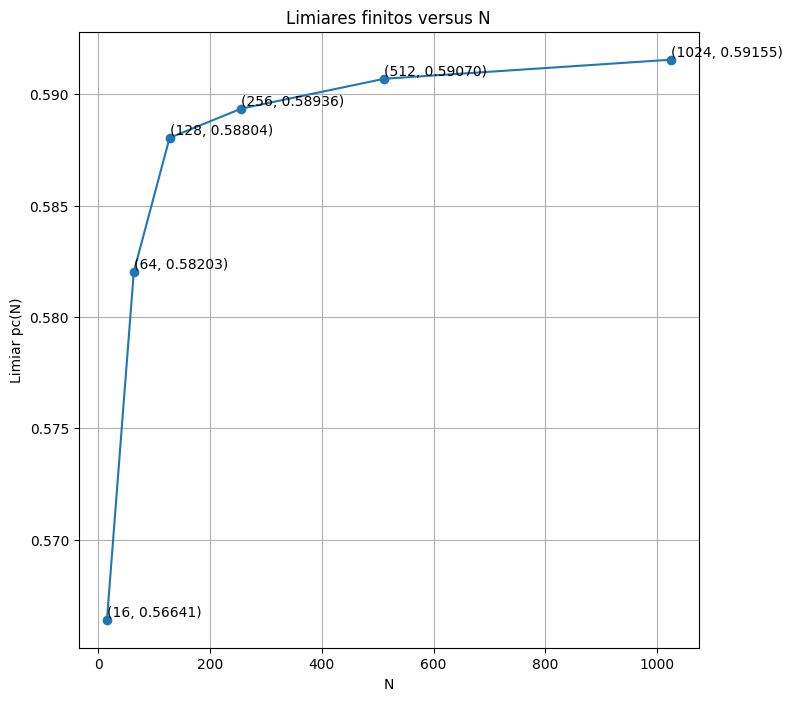

In [20]:
np.random.seed(42)
limiar_critico(500)

---

# **Resultados**

### **Gráfico de distribuição: tamanho dos maiores clusters**

In [ ]:
def grafico_tam_clusters(N, p, n):
  '''Os parâmetros são os mesmos da função metricas_cluster(N, p, n). 
  Gera dois gráficos comparativos com as métricas dos sistemas/matrizes que percolam e que não percolam'''
  dados = metricas_cluster(N, p, n)
  tam_cluster_percola, tam_cluster_nao_percola, prob_percolar, prob_nao_percolar, media_tam_percola, media_tam_nao_percola, total_percola, total_nao_percola, num_cluster_percola, num_cluster_nao_percola, media_num_percola, media_num_nao_percola = dados

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  # Histograma percolação
  axes[0].hist(tam_cluster_percola, bins=30, edgecolor='black')
  axes[0].set_title(f"Percolou\nP={prob_percolar:.3f} | Média={media_tam_percola:.2f} | Total de matrizes: {total_percola} | Máximo: {max(tam_cluster_percola)}")
  axes[0].set_xlabel("Tamanho do maior cluster")
  axes[0].set_ylabel("Frequência")
  axes[0].grid(True)

  # Histograma NÃO percolação
  axes[1].hist(tam_cluster_nao_percola, bins=30, edgecolor='black')
  axes[1].set_title(f"Não Percolou\nP={prob_nao_percolar:.3f} | Média={media_tam_nao_percola:.2f} | Total de matrizes: {total_nao_percola} | Máximo: {max(tam_cluster_nao_percola)}")
  axes[1].set_xlabel("Tamanho do maior cluster")
  axes[1].grid(True)

  plt.suptitle(f"Distribuição do tamanho dos maiores clusters (N={N}, p={p}, n={n})", fontsize=16)
  plt.tight_layout()
  plt.show()

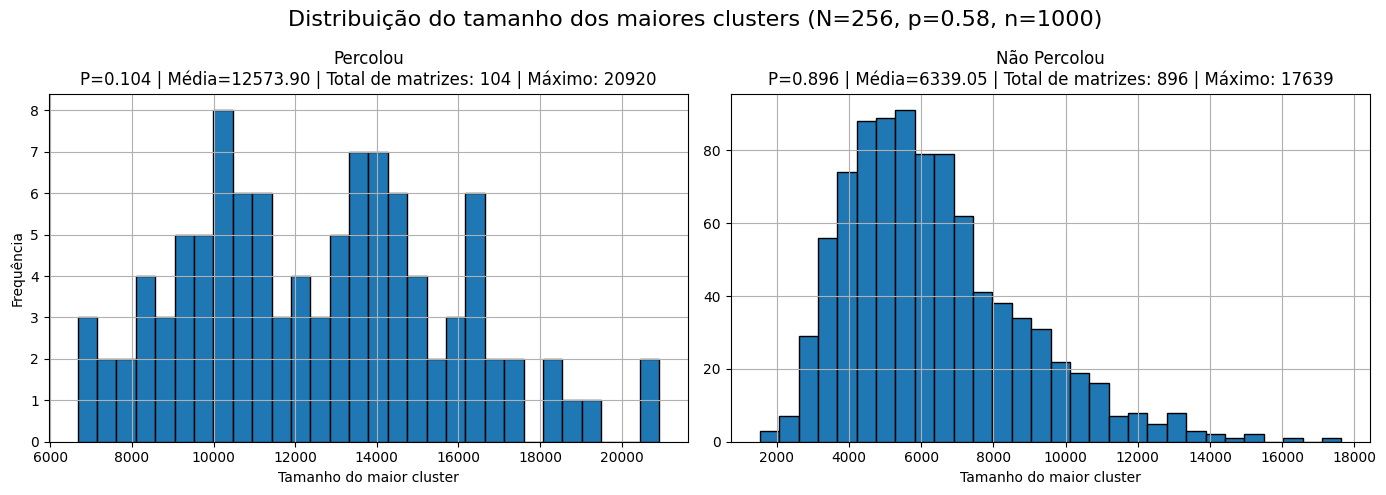

In [14]:
np.random.seed(42)
grafico_tam_clusters(256, 0.58, 1000)

### **Gráfico de distribuição: número de clusters**

In [ ]:
def grafico_num_clusters(N, p, n):
  '''Os parâmetros são os mesmos da função media_cluster(N, p, n). 
  Gera dois gráficos comparativos com as métricas dos sistemas/matrizes que percolam e que não percolam,
  comparando a distribuição do total de clusters'''
  dados = metricas_cluster(N, p, n)
  tam_cluster_percola, tam_cluster_nao_percola, prob_percolar, prob_nao_percolar, media_tam_percola, media_tam_nao_percola, total_percola, total_nao_percola, num_cluster_percola, num_cluster_nao_percola, media_num_percola, media_num_nao_percola = dados

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  # Histograma para sistemas que percolam
  axes[0].hist(num_cluster_percola, bins=30, edgecolor='black')
  axes[0].set_title(f"Percolou \nMédia={media_num_percola:.2f} | Total de matrizes: {total_percola} | Máximo: {max(num_cluster_percola)}")
  axes[0].set_xlabel("Total de clusters")
  axes[0].set_ylabel("Frequência")
  axes[0].grid(True)

  # Histograma para sistemas que NÃO percolam
  axes[1].hist(num_cluster_nao_percola, bins=30, edgecolor='black')
  axes[1].set_title(f"Não percolou \nMédia={media_num_nao_percola:.2f} | Total de matrizes: {total_nao_percola} | Máximo: {max(num_cluster_nao_percola)}")
  axes[1].set_xlabel("Número total de clusters")
  axes[1].grid(True)

  plt.suptitle(f"Distribuição do número de clusters (N={N}, p={p}, n={n})", fontsize=16)
  plt.tight_layout()
  plt.show()

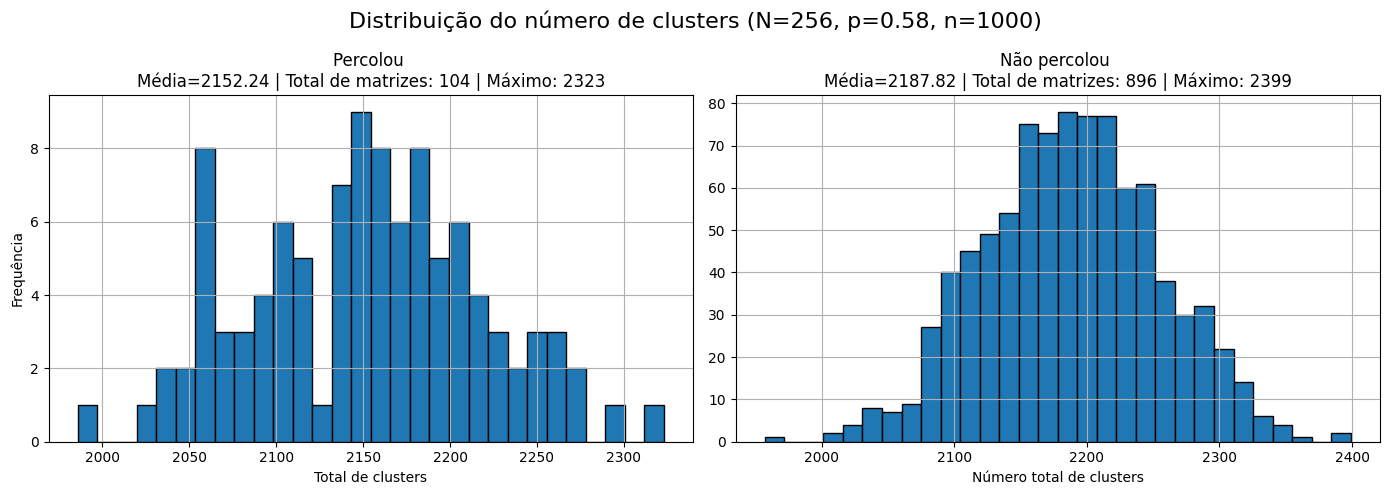

In [16]:
np.random.seed(42)
grafico_num_clusters(256, 0.58, 1000)